<a href="https://colab.research.google.com/github/Tempest-Sama/Projects/blob/main/Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#load the dataset
data=pd.read_csv("spam.csv", encoding="latin-1")
#Explore the data
print(data.head())
print(data.info())
print(data.count())

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
m

In [ ]:
#Dropping extra columns which have no impact on our main data
data=data.drop(["Unnamed: 2","Unnamed: 3","Unnamed: 4"], axis=1)
data=data.rename(columns={"v1":"ham","v2":"text"})
print(data.head())

    ham                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [ ]:
print(data.count())

ham     5572
text    5572
dtype: int64


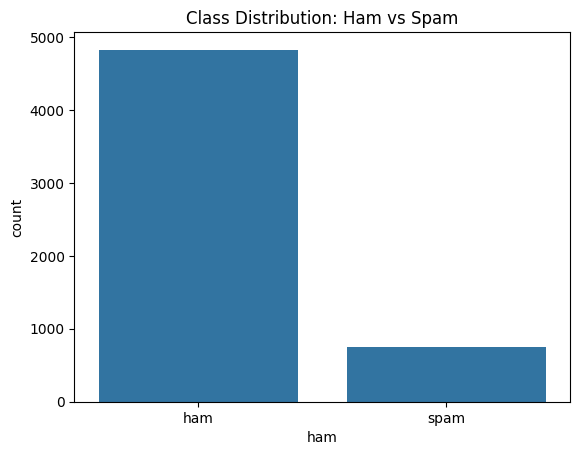

In [ ]:
#visualize class distribution
sns.countplot(x="ham", data=data)
plt.title("Class Distribution: Ham vs Spam")
plt.show()

In [ ]:
import string
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
#download necessary nltk resources
import nltk
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
data['text'] = data['text'].astype(str).str.lower()  # Ensure 'text' column is of type string and lowercase
data['text'] = data['text'].apply(lambda x: re.sub(r'\d+', '', x) if isinstance(x, str) else x) #remove numbers
data['text'] = data['text'].str.translate(str.maketrans('', '', string.punctuation)) #Remove punctuation
data['text'] = data['text'].str.split()
data['text']= [word for word in data['text'] if word not in stopwords.words('english')]
lemmatizer=WordNetLemmatizer()
data['text'] = data['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [ ]:
data['processed_message'] = data['text'].apply(lambda x: ' '.join(x))
x=data['processed_message']
y=data['ham'].map({'ham':0,'spam':1})
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.head())

1978    no im in the same boat still here at my mom ch...
3989    bank of granite issue strongbuy explosive pick...
3935        they r giving a second chance to rahul dengra
4078               o i played smash bros ltgt religiously
4086    private your account statement for show unrede...
Name: processed_message, dtype: object


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
#convert text into Numerical feature
vectorizer=TfidfVectorizer(max_features=5000)
x_train_tfidf=vectorizer.fit_transform(x_train)
x_test_tfidf=vectorizer.transform(x_test)
print(x_train_tfidf.shape)

(4457, 5000)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#Train multiple models
models= {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "SVM":SVC(kernel='linear', probability=True)
}
for name, model in models.items():
  model.fit(x_train_tfidf, y_train)
print(f"{name} Model Trained!")

SVM Model Trained!


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Evaluate models
for name, model in models.items():
    y_pred = model.predict(x_test_tfidf)
    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")

--- Naive Bayes ---
Accuracy: 0.9561
Precision: 1.0000
Recall: 0.6733
F1 Score: 0.8048
Confusion Matrix:
[[965   0]
 [ 49 101]]


--- Logistic Regression ---
Accuracy: 0.9641
Precision: 1.0000
Recall: 0.7333
F1 Score: 0.8462
Confusion Matrix:
[[965   0]
 [ 40 110]]


--- SVM ---
Accuracy: 0.9812
Precision: 0.9850
Recall: 0.8733
F1 Score: 0.9258
Confusion Matrix:
[[963   2]
 [ 19 131]]




In [ ]:
from sklearn.model_selection import GridSearchCV

# Example: Tuning Logistic Regression
param_grid = {'C': [0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='f1')
grid.fit(x_train_tfidf, y_train)

# Best parameters and performance
print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_

# Evaluate best model
y_pred = best_model.predict(x_test_tfidf)
print(classification_report(y_test, y_pred))


Best Parameters: {'C': 10}
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.98      0.86      0.91       150

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [ ]:
#Addressing Class Imbalance
from imblearn.over_sampling import SMOTE

# Apply SMOTE to oversample spam messages
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(x_train_tfidf, y_train)

# Check the new class distribution
print("Class distribution after SMOTE:", pd.Series(y_train_balanced).value_counts())


Class distribution after SMOTE: ham
0    3860
1    3860
Name: count, dtype: int64


In [ ]:
#Threshold Tuning for Better Spam Recall
import numpy as np

# Fit Logistic Regression with the optimized hyperparameter
best_model = LogisticRegression(C=10, max_iter=1000)
best_model.fit(X_train_balanced, y_train_balanced)

# Predict probabilities instead of class labels
y_proba = best_model.predict_proba(x_test_tfidf)[:, 1]  # Probability for the spam class

# Tune threshold to improve recall
threshold = 0.4  # Lower threshold to prioritize spam detection
y_pred_tuned = (y_proba >= threshold).astype(int)

# Evaluate performance with the new threshold
from sklearn.metrics import classification_report, confusion_matrix

print(f"Classification Report with Threshold {threshold}:\n")
print(classification_report(y_test, y_pred_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))


Classification Report with Threshold 0.4:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       965
           1       0.91      0.91      0.91       150

    accuracy                           0.97      1115
   macro avg       0.95      0.95      0.95      1115
weighted avg       0.97      0.97      0.97      1115

Confusion Matrix:
 [[951  14]
 [ 14 136]]


In [ ]:
# Add custom features
data['message_length'] = data['text'].apply(len)
data['special_characters'] = data['text'].apply(lambda x: sum([1 for char in x if char in string.punctuation]))

# Combine TF-IDF features with custom features
from scipy.sparse import hstack

# Generate custom feature matrix
custom_features = data[['message_length', 'special_characters']].values
X_train_custom = hstack([x_train_tfidf, custom_features[:len(x_train)]])
X_test_custom = hstack([x_test_tfidf, custom_features[len(x_train):]])

# Reapply SMOTE with new features
X_train_custom_balanced, y_train_custom_balanced = smote.fit_resample(X_train_custom, y_train)


In [ ]:
# Train on enhanced features
final_model = LogisticRegression(C=10, max_iter=1000)
final_model.fit(X_train_custom_balanced, y_train_custom_balanced)

# Predict probabilities for the enhanced model
y_proba_custom = final_model.predict_proba(X_test_custom)[:, 1]

# Tune threshold and evaluate
threshold_custom = 0.4
y_pred_final = (y_proba_custom >= threshold_custom).astype(int)

print("Final Model Evaluation with Custom Features and SMOTE:")
print(classification_report(y_test, y_pred_final))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_final))


Final Model Evaluation with Custom Features and SMOTE:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       965
           1       0.91      0.91      0.91       150

    accuracy                           0.97      1115
   macro avg       0.95      0.95      0.95      1115
weighted avg       0.97      0.97      0.97      1115

Confusion Matrix:
 [[951  14]
 [ 14 136]]


<ipython-input-54-33392fed8a04>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=test_data, x='Prediction Status', palette='viridis')


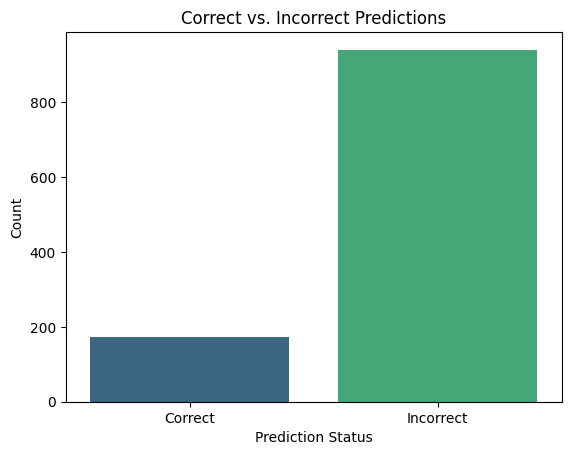

In [ ]:
test_data = data.iloc[len(x_train):].copy() # Select the test data portion
test_data['Actual Label'] = y_test
test_data['Predicted Label'] = y_pred_final

# Calculate correct and incorrect predictions
test_data['Prediction Status'] = test_data.apply(
    lambda row: 'Correct' if row['Actual Label'] == row['Predicted Label'] else 'Incorrect',
    axis=1
)

# Plot the breakdown
sns.countplot(data=test_data, x='Prediction Status', palette='viridis')
plt.title("Correct vs. Incorrect Predictions")
plt.xlabel("Prediction Status")
plt.ylabel("Count")
plt.show()

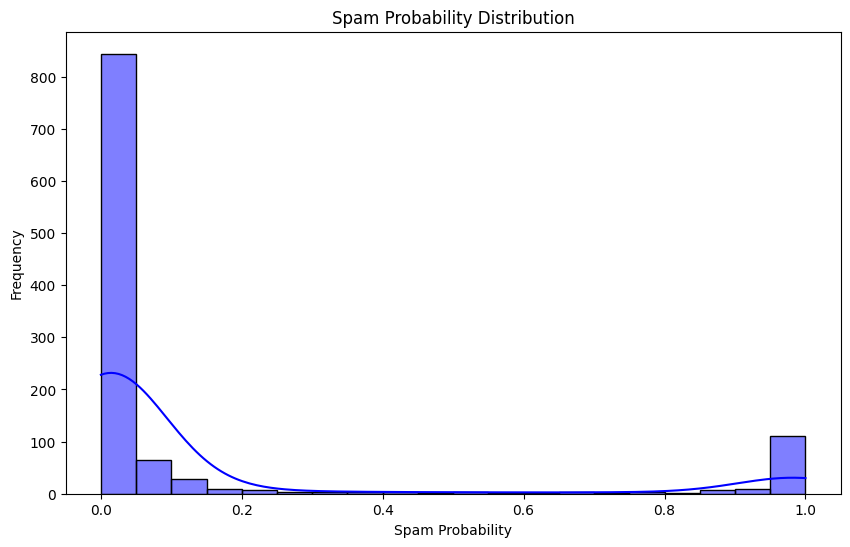

In [ ]:
test_data['Spam Probability'] = y_proba_custom

# Plot spam probability distribution
plt.figure(figsize=(10, 6))
sns.histplot(test_data['Spam Probability'], bins=20, kde=True, color='blue')
plt.title("Spam Probability Distribution")
plt.xlabel("Spam Probability")
plt.ylabel("Frequency")
plt.show()

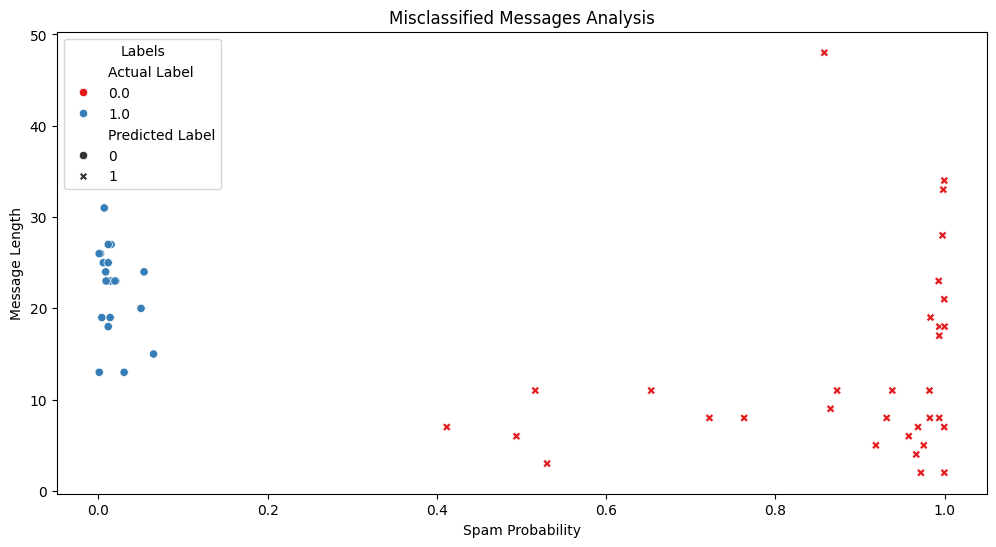

In [ ]:
# Filter misclassified messages
misclassified = test_data[test_data['Prediction Status'] == 'Incorrect']

# Scatter plot for misclassified messages
plt.figure(figsize=(12, 6))
sns.scatterplot(data=misclassified, x='Spam Probability', y='message_length', hue='Actual Label', style='Predicted Label', palette='Set1')
plt.title("Misclassified Messages Analysis")
plt.xlabel("Spam Probability")
plt.ylabel("Message Length")
plt.legend(title="Labels")
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

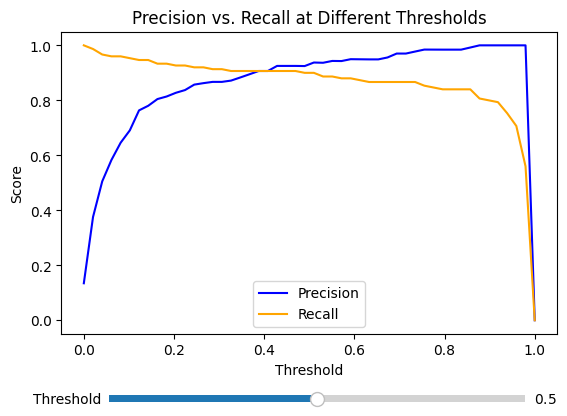

In [ ]:
from matplotlib.widgets import Slider

# Create a function to plot precision and recall at various thresholds
thresholds = np.linspace(0, 1, 50)
precision, recall = [], []

for threshold in thresholds:
    y_pred = (final_model.predict_proba(X_test_custom)[:, 1] >= threshold).astype(int)
    report = classification_report(y_test, y_pred, output_dict=True)
    precision.append(report['1']['precision'])
    recall.append(report['1']['recall'])

# Plot initial values
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)
l, = plt.plot(thresholds, precision, label="Precision", color="blue")
r, = plt.plot(thresholds, recall, label="Recall", color="orange")
plt.title("Precision vs. Recall at Different Thresholds")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()

# Slider for threshold tuning
ax_slider = plt.axes([0.2, 0.1, 0.65, 0.03])
slider = Slider(ax_slider, 'Threshold', 0.0, 1.0, valinit=0.5)

def update(val):
    threshold = slider.val
    y_pred = (final_model.predict_proba(X_test_custom)[:, 1] >= threshold).astype(int)
    precision_val = classification_report(y_test, y_pred, output_dict=True)['1']['precision']
    recall_val = classification_report(y_test, y_pred, output_dict=True)['1']['recall']
    l.set_ydata([precision_val if t <= threshold else 0 for t in thresholds])
    r.set_ydata([recall_val if t <= threshold else 0 for t in thresholds])
    fig.canvas.draw_idle()

slider.on_changed(update)
plt.show()


In [ ]:
!pip install mpld3  # Install the mpld3 library
import mpld3 # Import the library for interactive plotting
# Save as PNG
plt.savefig("spam_probability_distribution.png")

# Save as HTML (if using Plotly or mpld3 for interactivity)

html_file = mpld3.fig_to_html(fig) # Convert figure to html
with open("interactive_plot.html", "w") as f:
    f.write(html_file)  #write html to file

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 3.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/mpld3/mplexporter/exporter.py:84: UserWarning: Blended transforms not yet supported. Zoom behavior may not work as expected.
  warnings.warn("Blended transforms not yet supported. "


<Figure size 640x480 with 0 Axes>

<ipython-input-67-72de43409eb7>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=test_data, x='Prediction Status', palette='viridis')


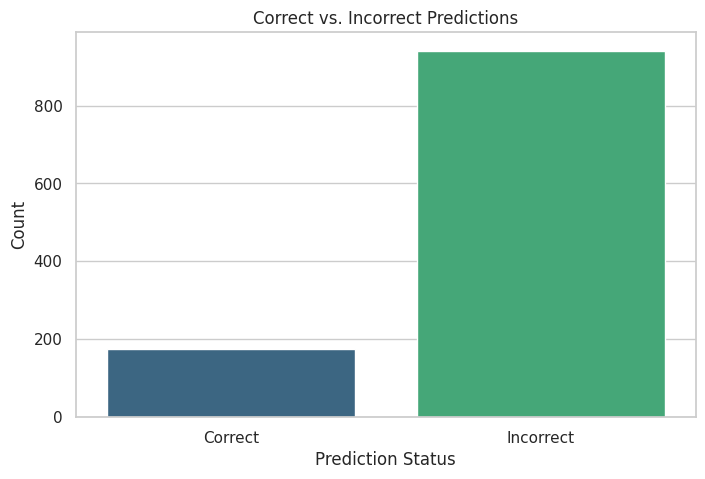

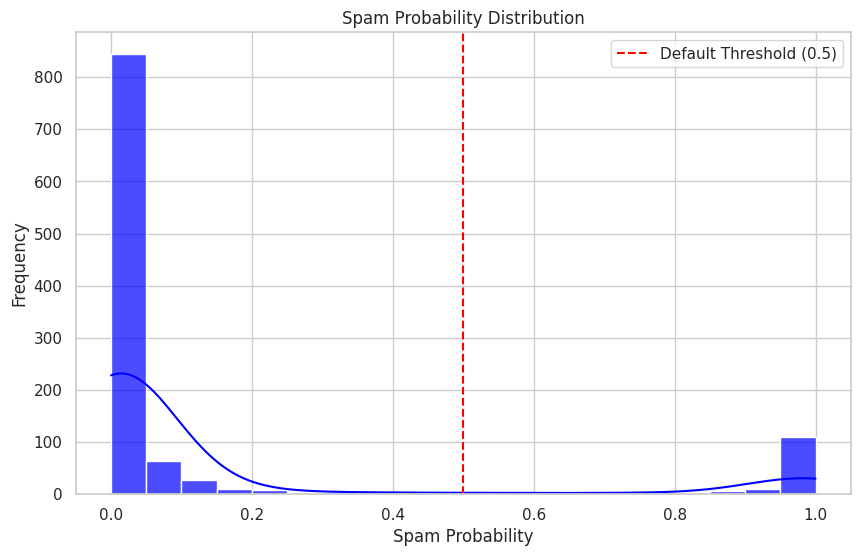

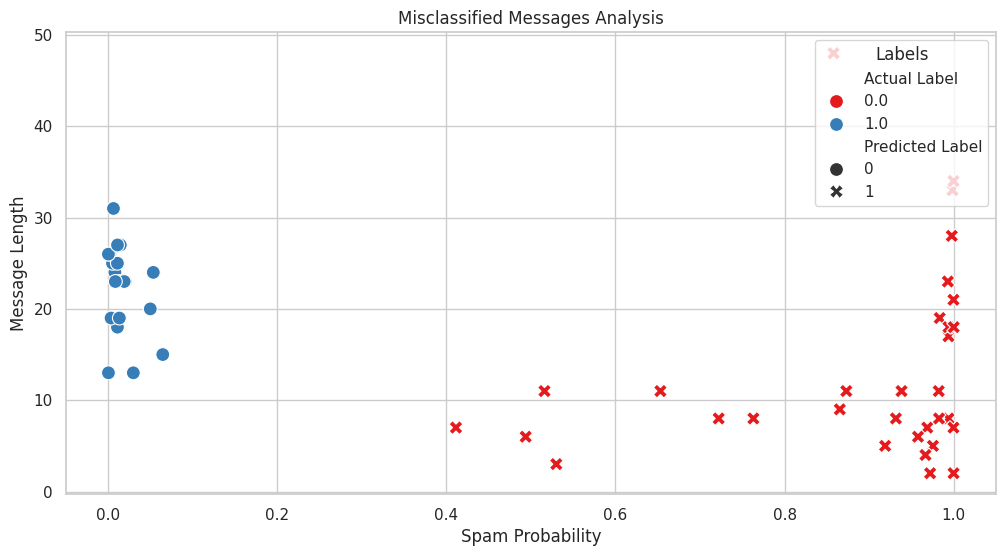

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

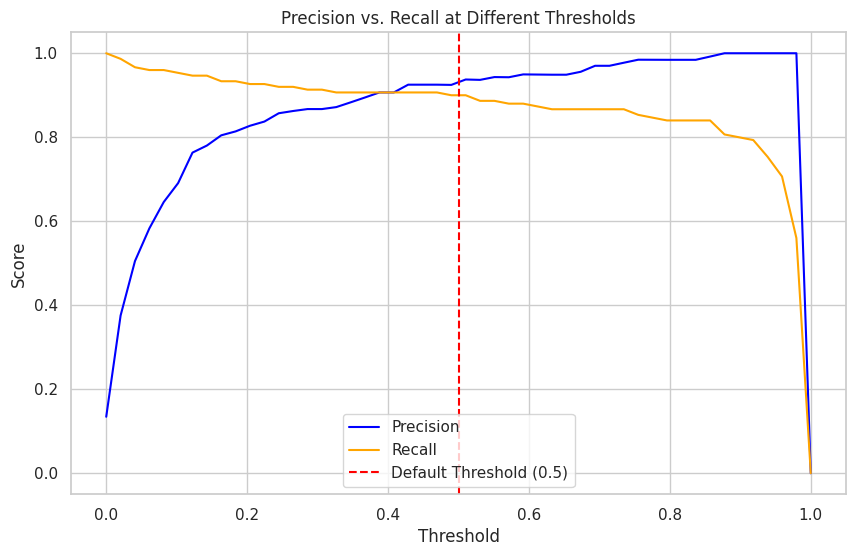

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Ensure Seaborn style
sns.set_theme(style="whitegrid")

# Prepare Data for Visualization
test_data['Prediction Status'] = test_data.apply(
    lambda row: 'Correct' if row['Actual Label'] == row['Predicted Label'] else 'Incorrect',
    axis=1
)

# Extract misclassified messages for detailed analysis
misclassified = test_data[test_data['Prediction Status'] == 'Incorrect']

# Visualization 1: Accuracy Breakdown
plt.figure(figsize=(8, 5))
sns.countplot(data=test_data, x='Prediction Status', palette='viridis')
plt.title("Correct vs. Incorrect Predictions")
plt.xlabel("Prediction Status")
plt.ylabel("Count")
plt.savefig("accuracy_breakdown.png", dpi=300)  # Save as PNG
plt.show()

# Visualization 2: Spam Probability Distribution
plt.figure(figsize=(10, 6))
sns.histplot(test_data['Spam Probability'], bins=20, kde=True, color='blue', alpha=0.7)
plt.axvline(0.5, color='red', linestyle='--', label='Default Threshold (0.5)')
plt.title("Spam Probability Distribution")
plt.xlabel("Spam Probability")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("spam_probability_distribution.png", dpi=300)
plt.show()

# Visualization 3: Misclassification Analysis
plt.figure(figsize=(12, 6))
sns.scatterplot(data=misclassified, x='Spam Probability', y='message_length',
                hue='Actual Label', style='Predicted Label', palette='Set1', s=100)
plt.title("Misclassified Messages Analysis")
plt.xlabel("Spam Probability")
plt.ylabel("Message Length")
plt.legend(title="Labels", loc='upper right')
plt.savefig("misclassified_analysis.png", dpi=300)
plt.show()

# Visualization 5: Precision-Recall Tradeoff (Threshold Tuning)
thresholds = np.linspace(0, 1, 50)
precision, recall = [], []

for threshold in thresholds:
    y_pred = (final_model.predict_proba(X_test_custom)[:, 1] >= threshold).astype(int)
    report = classification_report(y_test, y_pred, output_dict=True)
    precision.append(report['1']['precision'])
    recall.append(report['1']['recall'])

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision, label="Precision", color="blue")
plt.plot(thresholds, recall, label="Recall", color="orange")
plt.axvline(0.5, color='red', linestyle='--', label='Default Threshold (0.5)')
plt.title("Precision vs. Recall at Different Thresholds")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.savefig("precision_recall_tradeoff.png", dpi=300)
plt.show()
